In [182]:
import feedparser
import DCDSFunctions as f
import pandas as pd
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [183]:
# Stack Overflow 
# responsible scraping is ok
# https://meta.stackoverflow.com/questions/348954/can-i-scrape-stack-overflow-job-postings

# Have an API requiring a authorization code
# stackoverflow_url = 'https://talent.stackoverflow.com/api/job-slots?'

# Simpler to use the results from a query that they post as an RSS Feed

# DC Jobs
SO_DC_feed_url = 'https://stackoverflow.com/jobs/feed?q=data+scientist&l=Washington+D.C.%2c+DC%2c+USA&u=Miles&d=50'
SO_DC_feed = feedparser.parse(SO_DC_feed_url) 
SO_DC_sorted = f.stackoverflow_feed_sorter(SO_DC_feed)

# National
SO_Nat_feed_url = 'https://stackoverflow.com/jobs/feed?q=data+scientist'
SO_Nat_feed = feedparser.parse(SO_Nat_feed_url)
SO_Nat_sorted = f.stackoverflow_feed_sorter(SO_Nat_feed)

In [184]:
# function to check old results against new
# function to parse job summary

SO_DC_table = pd.DataFrame(SO_DC_sorted)
SO_Nat_table = pd.DataFrame(SO_Nat_sorted)

In [185]:
filename = 'data/stackoverflow_DC_'+datetime.datetime.now().strftime('%Y%m%d')
outfile = open(filename,'wb')
pickle.dump(SO_DC_table,outfile)
outfile.close()

filename = 'data/stackoverflow_Nat_'+datetime.datetime.now().strftime('%Y%m%d')
outfile = open(filename,'wb')
pickle.dump(SO_Nat_table,outfile)
outfile.close()

<b> H1B1 Data Information </b>

In [335]:
# H1BDATA.info
import requests
from bs4 import BeautifulSoup
import time
import random

In [336]:
# Sample query
years = list(range(2014,2020))
years = [str(y) for y in years]
years

['2014', '2015', '2016', '2017', '2018', '2019']

In [337]:
# Scrap Job Title Information

job_title_url = 'https://h1bdata.info/topjobs.php'
title_resp = requests.get(job_title_url)

titles_all = BeautifulSoup(title_resp.content, 'html.parser') # soup type
title_block = titles_all.find('tbody') # element.Tag
title_rows = title_block.findAll('tr') # element.ResultSet which is a list of Tags
title_links= [x.findAll('a') for x in title_rows] # list of list each with one element.Tag
title_data = [x[0].get_text()  for x in title_links if x]

DS_titles = [x.lower().replace(' ','+') for x in title_data if 'DATA SCI' in x]
DS_titles

['data+scientist',
 'senior+data+scientist',
 'associate+data+scientist',
 'data+scientist+ii',
 'data+scientist+i',
 'sr.+data+scientist',
 'lead+data+scientist',
 'data+science+engineer',
 'data+science+analyst',
 'senior+associate,+data+science']

In [338]:
# Manual Save Path Keywords
# automate!
save_titles= ['DSgen','SeniorDS','AssocDS','DSII','DSI','SrDS','LeadDS','DSEng','DSAnalyst','SenAssocDS']

In [339]:
# Scrape Job Information and Pickle

for ind,title in enumerate(DS_titles):
    save_title = save_titles[ind]

    for year in years:
        h1b1_url = 'https://h1bdata.info/index.php?em=&job='+title+'&city=&year='+year

        resp = requests.get(h1b1_url)

        h1b1_annual = BeautifulSoup(resp.content, 'html.parser')
        block = h1b1_annual.find('tbody')
        data = block.findAll('tr')
        t = [x.findAll('td') for x in data]

        col = ['Company','Role','Salary','Location','SubmitDate','StartDate','Status']
        ls = []
        for row in t:
            vals = [x.text for x in row]
            dic = dict(zip(col,vals))
            ls.append(dic)

        h1b1 = pd.DataFrame(ls)
        pause = random.randrange(3,15)
        print('Pausing for ',pause,' seconds...')
        time.sleep(pause)

        filename = 'data/h1b1data_'+save_title+'_'+year+'.p'
        outfile = open(filename,'wb')
        pickle.dump(h1b1,outfile)
        outfile.close()

Pausing for  4  seconds...
Pausing for  12  seconds...
Pausing for  6  seconds...
Pausing for  3  seconds...
Pausing for  12  seconds...
Pausing for  10  seconds...
Pausing for  4  seconds...
Pausing for  13  seconds...
Pausing for  10  seconds...
Pausing for  5  seconds...
Pausing for  13  seconds...
Pausing for  9  seconds...
Pausing for  3  seconds...
Pausing for  9  seconds...
Pausing for  8  seconds...
Pausing for  8  seconds...
Pausing for  14  seconds...
Pausing for  8  seconds...
Pausing for  5  seconds...
Pausing for  13  seconds...
Pausing for  6  seconds...
Pausing for  11  seconds...
Pausing for  12  seconds...
Pausing for  10  seconds...
Pausing for  7  seconds...
Pausing for  3  seconds...
Pausing for  13  seconds...
Pausing for  14  seconds...
Pausing for  12  seconds...
Pausing for  4  seconds...
Pausing for  10  seconds...
Pausing for  5  seconds...
Pausing for  6  seconds...
Pausing for  12  seconds...
Pausing for  13  seconds...
Pausing for  7  seconds...
Pausing for

In [317]:
# Load data and merge to one DataFrame

h1b1_all = pd.DataFrame()

for ind,title in enumerate(save_titles):
    
    for i, year in enumerate(years):
        
        filename = 'data/h1b1data_'+title+'_'+year+'.p'
        infile = open(filename,'rb')
        t = pickle.load(infile)
        t['Year'] = year

        if ((ind == 0) & (i == 0)):
            h1b1_all = t
        elif sum(t.shape)>=1:
            h1b1_all = pd.concat([h1b1_all,t], ignore_index=True, sort=True)
            

In [191]:
h1b1_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453 entries, 0 to 7452
Data columns (total 8 columns):
Company       7453 non-null object
Location      7453 non-null object
Role          7453 non-null object
Salary        7453 non-null object
StartDate     7453 non-null object
Status        7453 non-null object
SubmitDate    7453 non-null object
Year          7453 non-null object
dtypes: object(8)
memory usage: 465.9+ KB


In [318]:
h1b1_all.Salary = h1b1_all.Salary.map(lambda x: x.replace(',','')).map(int)
h1b1_all.Year = h1b1_all.Year.map(int)

In [319]:
h1b1 = h1b1_all[h1b1_all['Status'] == 'CERTIFIED'].reset_index(drop = True)

print( str( round( len(h1b1) / len(h1b1_all)*100, 1)) + '%')

95.7%


In [320]:
h1b1[h1b1['Salary']>300000]

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
2722,LARSON LIVING LABS LLC,"CAMBRIDGE, MA",DATA SCIENTIST,312000,03/28/2018,CERTIFIED,03/21/2018,2018
2723,LARSON LIVING LABS LLC,"CAMBRIDGE, MA",DATA SCIENTIST,312000,06/01/2018,CERTIFIED,05/14/2018,2018


In [321]:
h1b1[h1b1['Salary']<40000]

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
76,THREATMETRIX INC,"SAN JOSE, CA",DATA SCIENTIST,5769,01/26/2015,CERTIFIED,01/06/2015,2015
615,DOMINION ENTERPRISES,"NORFOLK, VA",DATA SCIENTIST,29973,08/31/2016,CERTIFIED,03/01/2016,2016
1489,UBER TECHNOLOGIES INC,"PITTSBURGH, PA",DATA SCIENTIST,37482,06/01/2017,CERTIFIED,01/13/2017,2017


In [322]:
# Drop Outliers
before_drop = len(h1b1)

h1b1 = h1b1[h1b1['Salary']>40000]# three values, likely typos or atypical contracts
h1b1 = h1b1[h1b1['Salary']<300000] # two values, larson living labs
h1b1 = h1b1.drop_duplicates()# several repeat entries

print( str( round(  before_drop/ len(h1b1_all)*100, 1)) + '%')

95.7%


<b> Let's plot </b>

In [323]:
pd.pivot_table(h1b1,values='Status',columns = 'Role',index = 'Year',aggfunc = 'count')

Role,DATA SCIENCE ANALYST,DATA SCIENCE ENGINEER,DATA SCIENTIST,DATA SCIENTIST I,DATA SCIENTIST II
Year,,,,,
2014,NaN,NaN,67.0,NaN,NaN
2015,4.0,5.0,514.0,3.0,7.0
2016,12.0,13.0,830.0,15.0,21.0
2017,46.0,19.0,1171.0,18.0,29.0
2018,32.0,43.0,1898.0,50.0,61.0
2019,16.0,48.0,1522.0,80.0,198.0


In [324]:
area_data = [ [0,0,67,0,0] , [4,5,514,3,7] , [12,13,830,15,21], [46,19,1171,18,29], [32,43,1898,50,61], [16,48,1522,80,198] ]
# area_data = [[0,4,12,46,32,16],[0,5,13,19,43,48],[67,514,830,1171,1898,1522],[0,3,15,18,50,80],[0,7,21,29,61,198]]
save_titles[:]

['DSgen', 'DSII', 'DSI', 'DSEng', 'DSAnalyst']

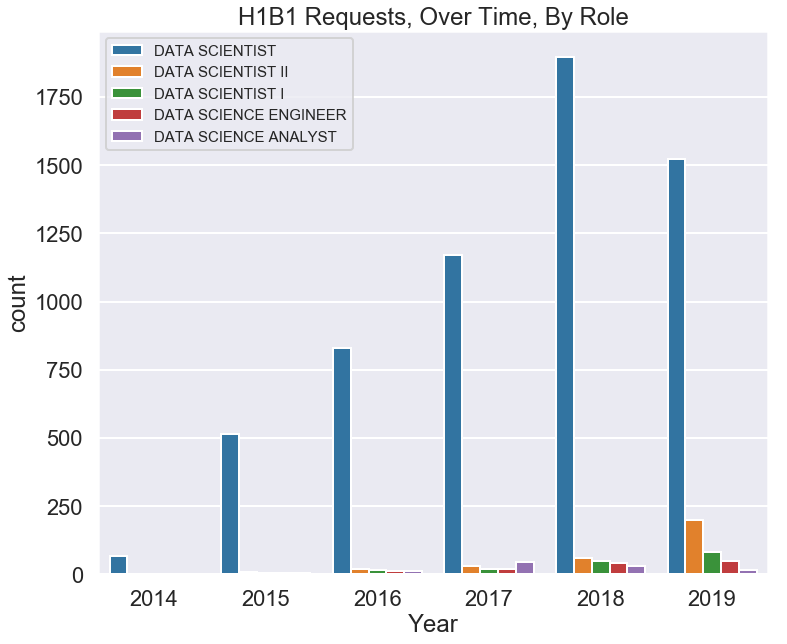

In [334]:
fig = plt.figure(figsize = (12,10))

ax = sns.countplot(x = 'Year', data = h1b1, hue = 'Role')
# ax = plt.stackplot(years[1:],area_data, labels = save_titles)
plt.title('H1B1 Requests, Over Time, By Role')
plt.legend(fontsize = 15, loc='upper left')

# sns.set_context('poster')
# sns.set_style("darkgrid")

fig.savefig("h1b1_applications_byrole.png")
plt.show()

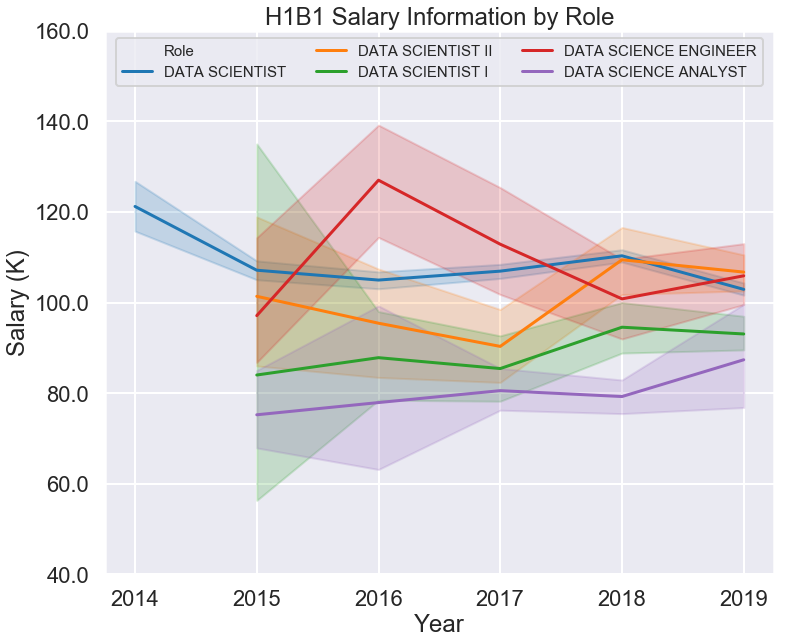

In [210]:
fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(x="Year", y="Salary", data=h1b1, hue = 'Role')

locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
plt.title('H1B1 Salary Information by Role')

plt.legend(ncol = 3, fontsize = 15, loc='')

sns.set_context('poster')
sns.set_style("darkgrid")

fig.savefig("h1b1_salaries_byrole.png")
plt.show()

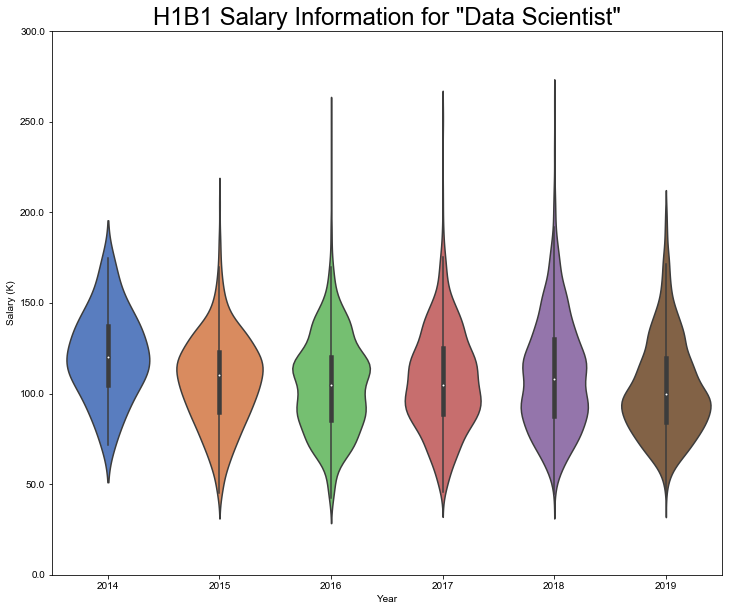

In [181]:
fig = plt.figure(figsize = (12,10))
ax = sns.violinplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette="muted")
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")
plt.title('H1B1 Salary Information for "Data Scientist"')
# fig.savefig("h1b1_violin.png")
plt.show()

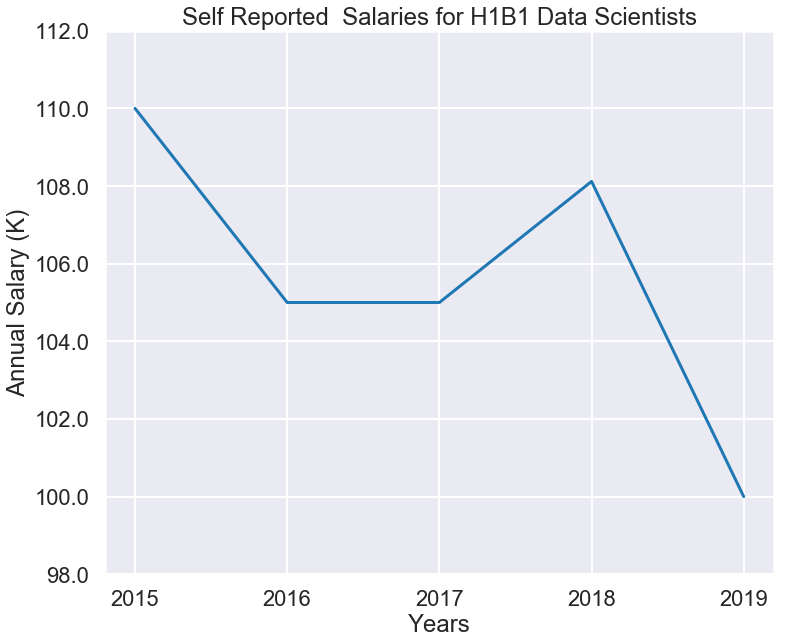

In [135]:
fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(years[1:],h1b1.groupby('Year').Salary.median())
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.yticks(locs, ticks/1000)
plt.xlabel('Years')
plt.ylabel('Annual Salary (K)')
plt.title('Self Reported  Salaries for H1B1 Data Scientists')
fig.savefig("h1b1_median.png")
plt.show()

In [ ]:
# Break out by industry and location

In [218]:
h1b1.loc[h1b1.Location.map(lambda x: ', MD' in x)].Location.sort_values().unique()

array(['BALTIMORE, MD', 'BETHESDA, MD', 'COLUMBIA, MD',
       'ELLICOTT CITY, MD', 'FREDERICK, MD', 'GERMANTOWN, MD',
       'LINTHICUM, MD', 'OLNEY, MD', 'ROCKVILLE, MD', 'SILVER SPRING, MD',
       'WEST NEW YORK, MD'], dtype=object)

In [219]:
# Create Regional Tags

# Example
h1b1.loc[h1b1.Location.map(lambda x: ', CA' in x)].Location.unique()
h1b1.loc[h1b1.Location.map(lambda x: ', NY' in x)].Location.unique()


bay_area = ['ALAMEDA, CA', 'BELMONT, CA', 'BENICIA, CA', 'BERKELEY, CA', 'BRISBANE, CA', 'BURLINGAME, CA', 'CAMPBELL, CA',
       'CUPERTINO, CA', 'DUBLIN, CA', 'EAST PALO ALTO, CA','EL CERRITO, CA', 'EMERYVILLE, CA', 'FOLSOM, CA',
       'FOSTER CITY, CA', 'FREMONT, CA',  'HERCULES, CA', 'LOS ALTOS, CA', 'LOS GATOS, CA', 'MENLO PARK, CA',
       'MILL VALLEY, CA', 'MILLBRAE, CA', 'MILPITAS, CA', 'MOUNTAIN VIEW, CA', 'NEWARK, CA', 'NOVATO, CA',
       'OAKLAND, CA', 'PALO  ALTO, CA', 'PALO ALTO, CA', 'PASADENA, CA', 'PETALUMA, CA', 'PLEASANT HILL, CA', 'PLEASANTON, CA',
       'REDLANDS, CA', 'REDWOOD CITY, CA', 'REDWOOD SHORES, CA', 'RICHMOND, CA', 'SAN BRUNO, CA', 'SAN CARLOS, CA',
       'SAN FANCISCO, CA', 'SAN FRANCICSCO, CA', 'SAN FRANCISCO, CA', 'SAN FRANCISCO, CA, CA', 'SAN JOSE, CA',  'SAN MATEO, CA',
       'SAN RAMON, CA', 'SANJOSE, CA', 'SAUSALITO, CA', 'SOUTH SAN FRANCISCO, CA', 'SUNNYVALE, CA', 'TIBURON, CA', 'UNION CITY, CA',
       'VALLEJO, CA', 'VENICE, CA', 'WALNUT CREEK, CA','SAN FRANCISCO, VA']



# bay_area = ['MOUNTAIN VIEW, CA', 'FREMONT, CA', 'SAN JOSE, CA', 'SAN FRANCISCO, CA', 'SAN MATEO, CA', 'MILPITAS, CA', 'PALO ALTO, CA', 'FOSTER CITY, CA', 'HOLLYWOOD, CA',
#         'MENLO PARK, CA', 'SANTA CLARA, CA', 'SAN CARLOS, CA', 'REDWOOD CITY, CA', 'CAMPBELL, CA', 'SUNNYVALE, CA', 'MILL VALLEY, CA',  'SAN FRANCISCO, CA, CA', 'EMERYVILLE, CA',
#         'CUPERTINO, CA', 'LOS ALTOS, CA', 'SAN BRUNO, CA', 'BURLINGAME, CA', 'BERKELEY, CA', 'NEWARK, CA', 'SAN FRANCICSCO, CA', 'PALO  ALTO, CA', 'OAKLAND, CA', 
#         'MILLBRAE, CA', 'DUBLIN, CA', 'SAUSALITO, CA', 'REDWOOD SHORES, CA', 'BRISBANE, CA', 'WALNUT CREEK, CA','NOVATO, CA', 'EAST PALO ALTO, CA', 'SANJOSE, CA','EL CERRITO, CA', 
#         'VALLEJO, CA', 'UNION CITY, CA', 'TIBURON, CA', 'LAFAYETTE, CA', 'SOUTH SAN FRANCISCO, CA', 'MODESTO, CA', 'RICHMOND, CA', 'BELMONT, CA', 'PLEASANT HILL, CA', 'SAN FANCISCO, CA',
#         'ALAMEDA, CA', 'TUSTIN, CA', 'PETALUMA, CA', 'REDLANDS, CA', 'AUSTIN, CA','LOS GATOS, CA','SAN FRANCISCO, VA']

nyc = ['NEW YORK, NY',  'BROOKLYN, NY', 'NEW  YORK, NY', 'NEW YORK CITY, NY', 'IRVINGTON, NY', 'LONG ISLAND CITY, NY', 'NYC, NY']
longisland = ['EAST MEADOW, NY','FARMINGDALE, NY', 'PORT WASHINGTON, NY','LONG BEACH, NY', 'MELVILLE, NY','LYNBROOK, NY','JERICHO, NY', 'UNIONDALE, NY']
westchester= ['ARMONK, NY','WHITE PLAINS, NY',  'YONKERS, NY','TARRYTOWN, NY','SPRING VALLEY, NY', 'SOMERS, NY','SOMMERS, NY','VALHALLA, NY','SOMERS, NY', 'YORKTOWN HEIGHTS, NY','YORKTOWN HIEGHTS, NY','WOODBURY, NY']

dmv = ['WASHINGTON, DC', 'WASHINGTON, DC, DC', 'WASHINGTON DC, DC','MCLEAN, VA','RETSON, VA', 'STERLING, VA', 'ALEXANDRIA, VA', 'ARLINGTON, VA', 'HERNDON, VA', 'ASHBURN, VA', 'MANASSAS, VA', 'RESTON, VA', 
    'FALLS CHURCH, VA','FAIRFAX, VA', 'DULLES, VA','BETHESDA, MD', 'SILVER SPRING, MD','COLUMBIA, MD','ROCKVILLE, MD']

# Add a columns for the split

h1b1['SV0_NYC1'] = [0  if x in bay_area else 1 if x in nyc else None for x in h1b1.Location]

h1b1['SV0_DMV2'] = [0  if x in bay_area else 2 if x in dmv else None for x in h1b1.Location]

h1b1['NYC1_DMV2'] = [2  if x in dmv else 1 if x in nyc else None for x in h1b1.Location]

In [235]:
h1b1_DS = h1b1[h1b1['Role']=='DATA SCIENTIST']
h1b1_DS.shape

(6002, 11)

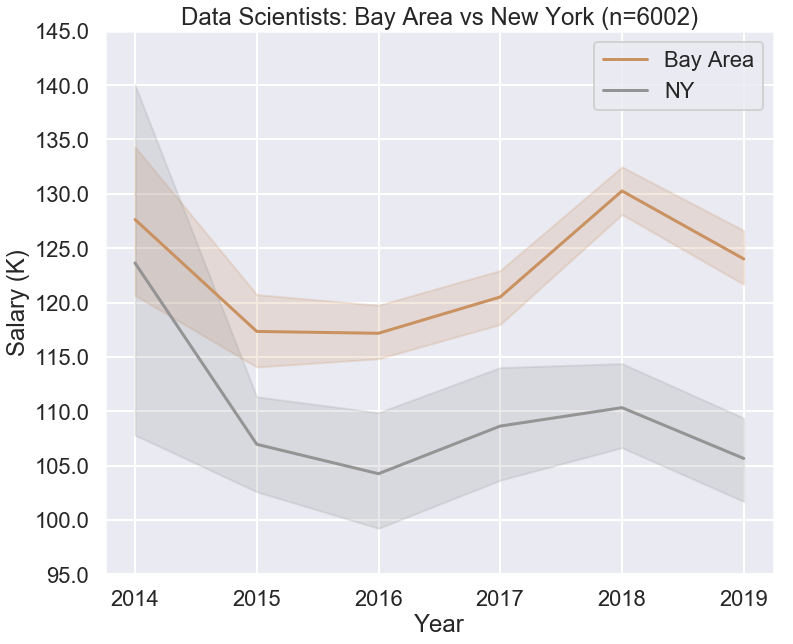

In [248]:
# Bay Area versus NY

fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette={0.0: sns.color_palette('colorblind')[5], 1.0: sns.color_palette('colorblind')[7]}, hue='SV0_NYC1')
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:],['Bay Area','NY'])

n_data = len(h1b1[h1b1['Role']=='DATA SCIENTIST'])

plt.title(f'Data Scientists: Bay Area vs New York (n={n_data})')
fig.savefig("h1b1_DSgen_NYC_SV.png")
plt.show()

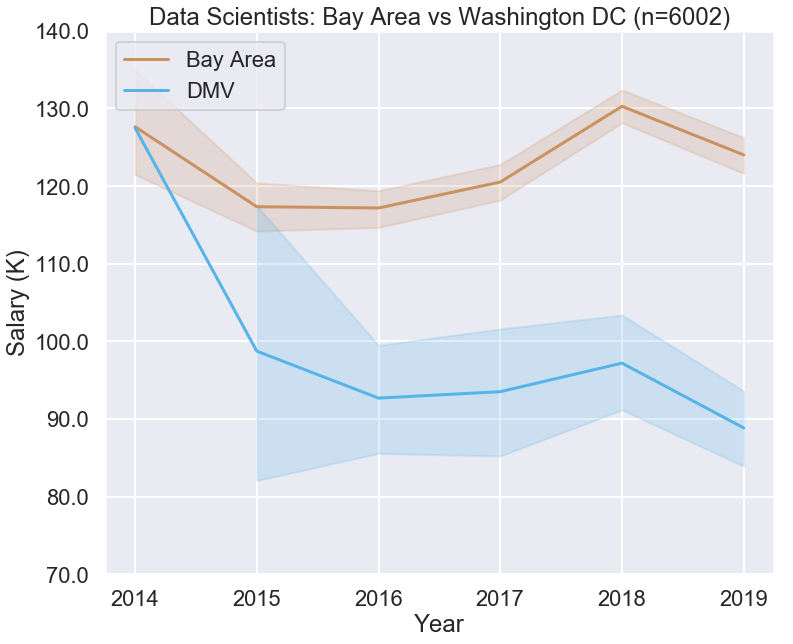

In [255]:
fig = plt.figure(figsize = (12,10))

ax = sns.lineplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette={0.0: sns.color_palette('colorblind')[5], 2.0: sns.color_palette('colorblind')[9]}, hue='SV0_DMV2')
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:],['Bay Area','DMV'])

n_data = len(h1b1[h1b1['Role']=='DATA SCIENTIST'])

plt.title(f'Data Scientists: Bay Area vs Washington DC (n={n_data})')
fig.savefig("h1b1_DSgen_DMV_SV.png")
plt.show()

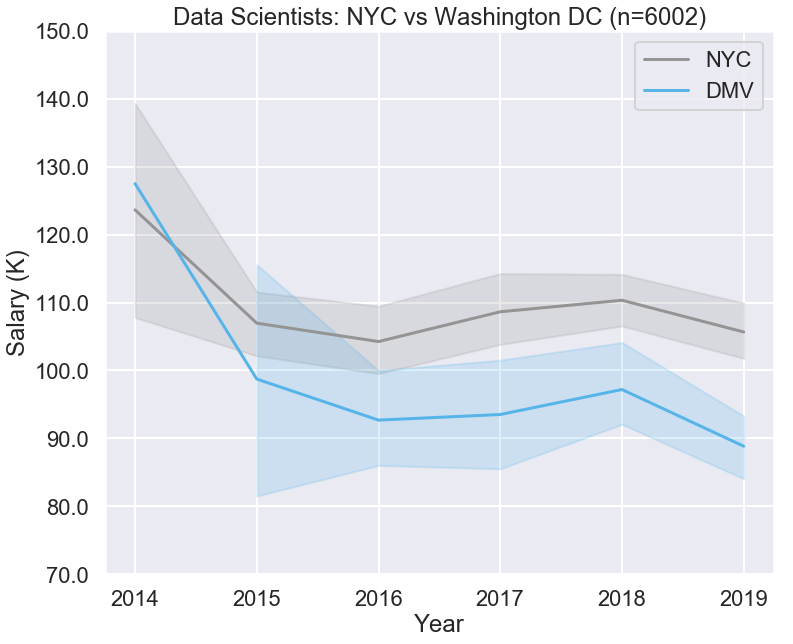

In [256]:
fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette={1.0: sns.color_palette('colorblind')[7], 2.0: sns.color_palette('colorblind')[9]}, hue='NYC1_DMV2')
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:],['NYC','DMV'])


n_data = len(h1b1[h1b1['Role']=='DATA SCIENTIST'])

plt.title(f'Data Scientists: NYC vs Washington DC (n={n_data})')
fig.savefig("h1b1_DSgen_NYC_DMV.png")
plt.show()

<b> Can we get access to any other job salary data? </b>

In [ ]:
# Glassdoor API requires partnership
# Salary no API, all aggregate statistics
# Payscale, Salary.com no API, all aggregate statistics

# Indeed API requires partnership

# You could use selenium and drive it to get salaries for different companies
# Same for Glassdoor and Monster Jobs

In [16]:
# DC Public employees
# https://dchr.dc.gov/public-employee-salary-information

# Only a handful of publically employed data scientists in DC, not worth it. 

<b> Job Search Information? </b>

In [15]:
# Monster Jobs robots.txt allws crawling over jobs/search?
# https://partner.monster.com/job-search-specification
import requests

# be ethical
crawl_delay = 15

In [15]:
monster_url = 'https://jsx.monster.com/query.ashx'
pars = {'rev':2.0}
# cat
monster_responses = requests.get(monster_url, params=)

In [145]:
# Request 

In [175]:
proxyapi_resp = requests.get('https://free-proxy-list.net/')

if proxyapi_resp.status_code == requests.codes.ok:
    # id = proxylisttable
    proxyapi_soup = BeautifulSoup(proxyapi_resp.content, 'html.parser')
    block = proxyapi_soup.find('tbody')
    data = block.findAll('tr')

    # t = [x.findAll('td') for x in data]
    cols = ['IP_Address','Port','Code','Country','Anonyimity','Google','https','LastChecked']

    t = [x.findAll('td') for x in data]

    ls = []
    for row in t:
        vals = [x.text for x in row]
        dic = dict(zip(cols,vals))
        ls.append(dic)

    proxies = pd.DataFrame(ls)
    elite_ip = proxies[(proxies['Anonyimity']=='elite proxy') & (proxies['Country']!='Russian Federation')] # they can't tell you are using a proxy

elite_ip # set data types here

,Anonyimity,Code,Country,Google,IP_Address,LastChecked,Port,https
0,elite proxy,BR,Brazil,no,187.111.192.198,18 seconds ago,59114,yes
1,elite proxy,BD,Bangladesh,no,103.106.33.73,18 seconds ago,54820,yes
2,elite proxy,TH,Thailand,no,1.179.206.201,18 seconds ago,37928,no
3,elite proxy,MU,Mauritius,no,197.231.186.148,18 seconds ago,35652,no
4,elite proxy,TW,Taiwan,no,122.116.232.79,18 seconds ago,61316,no
5,elite proxy,CZ,Czech Republic,no,93.99.179.133,18 seconds ago,8080,no
6,elite proxy,BR,Brazil,no,191.7.193.50,18 seconds ago,39693,yes
7,elite proxy,ID,Indonesia,no,36.89.183.51,18 seconds ago,53281,yes
8,elite proxy,BR,Brazil,no,45.235.87.65,18 seconds ago,49192,no
9,elite proxy,UA,Ukraine,no,46.201.249.7,18 seconds ago,32019,no
